# EE 445 Final Project (Part 2): Modeling effectiveness of government response
Nicholas Yama, Spring 2020

## Project goal

At the time of writing (07 May 2020) the United States is beginning to see the number of cases slowing, resulting in increase in desire by a vocal minority to return to normal operations. This would involve the uplifing of wide-scale quarantine and stay-at-home orders that, the evidence indicates has done significant good in slowing the spread of infections. Many arguments are being levied against the effectiveness of these restrictions which are often of dubious scientific merit.

The effectiveness of the government response has varied between states in curbing the number of cases and, due to the lack of national policy from the federal government, will likey be exacerbated as individual states begin to relax these measures. The goal of this project is to model the effectiveness of the government's response at a state level in terms of initial growth rates of the infection.

## Parameters

The number of infected individuals $N$ in its early stages generally can be modeled by an exponential curve

$$N=\exp(r(t-t_0))$$

where $r$ is the growth rate, $t$ is the time, and $t_0$ is the time until the first infection. The growth rate $r$ can then be determined by a linear regression on $\ln(N) = r(t - t_0)$.

This growth rate $r$ will be predicted using a linear regression-type network for the first 6 weeks starting March 1st (a day later the US would reach the first confirmed 100 cases).

The parameters of interest include:
1. The testing rate integrated weekly (so the number of tests administered from March 1 to a given week) normalized by the population (# tests adminstered/population, for 6 weeks).
2. Time from March 1 to declare a "state of emergency"
3. Time from March 1 to issue a stay-at-home order (state level)
4. Maximum number of persons at a gathering (in cases where a distinction is made between private and public gatherings, the maximum is taken)
5. Travel restrictions (1 = none, 2 = partial, 3 = mandatory).
6. School closures (1 = none, 2 = partial, 3 = all).
7. Daycare closures (1 = none, 2 = partial, 3 = all).
8. Restauraunts closures (1 = none, 2 = partial, 3 = all).
8. Non-essential retail closures (1 = none, 2 = partial, 3 = all).
9. Governor political affiliation (-1 = republican, 1 = democrat).
10. Population density (per square mile, control parameter).

When parameters associated with time of response were not achieved within the time frame provided (eg. no stay at home order issued within the 6 weeks) a value of 50 is assigned (greater than maximal value of 42).

Each data point will represent an individual state. Only the 50 states and the District of Columbia will be considered, territories of the US such as American Samoa and Puerto Rico will not be used.

### Data sources
[1] Target data to calculate the growth rate of cases, and the testing data was obtained via the COVID Tracking project: https://covidtracking.com/. The data was collected on May 06 (but data was only used up to April 12 so the collection date does not matter).

[2] Parameters 2-9 were obtained from the Wikipedia page: https://en.wikipedia.org/wiki/U.S._state_and_local_government_response_to_the_COVID-19_pandemic, I processed the data in Microsoft Excel, using a search and replace on terms corresponding to the values above.

[3] Governor partisanship (parameter 9) was found: https://en.wikipedia.org/wiki/List_of_United_States_governors

[4] State population statistics was found from the US 2010 Census projections for 2019. The full dataset can be found: https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html

# Loading and preprocessing data

In [1]:
import pandas as pd
import numpy as np

### Testing data

In [2]:
# Load testing dataset
url = 'https://raw.githubusercontent.com/nyama8/EE-445-Final-Project/master/testingdata.csv'
df = pd.read_csv(url, error_bad_lines=False)
df

,date,state,positive,negative,tests,time
0,20200412,AK,272.0,7766.0,8038,43
1,20200412,AL,3525.0,18058.0,21583,43
2,20200412,AR,1280.0,18442.0,19722,43
3,20200412,AS,0.0,3.0,3,43
4,20200412,AZ,3539.0,38570.0,42109,43
...,...,...,...,...,...,...
2101,20200302,RI,1.0,NaN,1,2
2102,20200302,WA,34.0,229.0,263,2
2103,20200301,MI,9.0,NaN,9,1
2104,20200301,RI,1.0,NaN,1,1


In [3]:
# Creates dictionary for state abbreviations and applies it to the dataframe
abbrv = []
with open('state_abbrev.txt', 'r') as reader:
    abbrv = reader.read().splitlines()

st_enum = dict([])
for i in range(len(abbrv)):
    st_enum[abbrv[i]] = i

print(st_enum)

df2 = df.replace({'state':st_enum})
num_df = df2.astype({'state' : 'int32'})
num_df.describe()

{'AK': 0, 'AL': 1, 'AR': 2, 'AZ': 3, 'CA': 4, 'CO': 5, 'CT': 6, 'DE': 7, 'FL': 8, 'GA': 9, 'HI': 10, 'IA': 11, 'ID': 12, 'IL': 13, 'IN': 14, 'KS': 15, 'KY': 16, 'LA': 17, 'MA': 18, 'MD': 19, 'ME': 20, 'MI': 21, 'MN': 22, 'MO': 23, 'MS': 24, 'MT': 25, 'NC': 26, 'ND': 27, 'NE': 28, 'NH': 29, 'NJ': 30, 'NM': 31, 'NV': 32, 'NY': 33, 'OH': 34, 'OK': 35, 'OR': 36, 'PA': 37, 'RI': 38, 'SC': 39, 'SD': 40, 'TN': 41, 'TX': 42, 'UT': 43, 'VA': 44, 'VT': 45, 'WA': 46, 'WI': 47, 'WV': 48, 'WY': 49, 'DC': 50, 'AS': 51, 'MP': 52, 'GU': 53, 'PR': 54, 'VI': 55}


,date,state,positive,negative,tests,time
count,2.106000e+03,2106.000000,2091.000000,1963.000000,2106.000000,2106.000000
mean,2.020035e+07,26.978158,2735.374462,13059.403464,14888.545584,24.536562
std,4.158387e+01,15.857036,11890.687767,26479.106277,35791.859537,11.099286
min,2.020030e+07,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.020032e+07,13.000000,17.000000,174.000000,144.000000,15.000000
50%,2.020032e+07,27.000000,194.000000,2989.000000,2433.000000,25.000000
75%,2.020040e+07,41.000000,1239.000000,14030.500000,13990.250000,34.000000
max,2.020041e+07,55.000000,188694.000000,272907.000000,461601.000000,43.000000


In [4]:
# Remove territories from data set
num_df = num_df[num_df['state'] <= 50]
num_df

,date,state,positive,negative,tests,time
0,20200412,0,272.0,7766.0,8038,43
1,20200412,1,3525.0,18058.0,21583,43
2,20200412,2,1280.0,18442.0,19722,43
4,20200412,3,3539.0,38570.0,42109,43
5,20200412,4,21794.0,168534.0,190328,43
...,...,...,...,...,...,...
2101,20200302,38,1.0,NaN,1,2
2102,20200302,46,34.0,229.0,263,2
2103,20200301,21,9.0,NaN,9,1
2104,20200301,38,1.0,NaN,1,1


In [5]:
# Get final data matrix and convert to numpy array
final_df = num_df.drop(columns=['date', 'negative'])
testing = final_df.to_numpy()
testing = testing.astype(int)
testing

array([[    0,   272,  8038,    43],
       [    1,  3525, 21583,    43],
       [    2,  1280, 19722,    43],
       ...,
       [   21,     9,     9,     1],
       [   38,     1,     1,     1],
       [   46,    30,   111,     1]])

In [6]:
# Re-express data in 51x43 matrix, each row is a particular state, each column a particular day after March 1
cases_by_state = np.zeros([51,43])

# Get total tests by week (March 1, March 8, March 15, ...)
testing_by_week = np.zeros([51,7])

week = 0
for row in testing:
    #print(row)
    try:
        cases_by_state[row[0],row[3]] = row[1]
    except:
        pass
    
    # Generates integrated testing rates
    week = int(row[3] / 7)
    #print(week)
    if row[3] % 7  == 1:
        testing_by_week[row[0], week] = row[2] 
    week = week + 1
    
#print(cases_by_state)
#print(testing_by_week)

### State response

In [7]:
url = 'https://raw.githubusercontent.com/nyama8/EE-445-Final-Project/master/state_statistics.csv'
df = pd.read_csv(url, error_bad_lines=False)
#df

In [8]:
df2 = df.replace({'state':st_enum})
df3 = df2.astype({'state' : 'int32'})
df3

,state,population,density,emergency,quarantine,gatherings,travel,school,daycares,restauraunts,retail,party
0,0,731545,1,10,27,10,3,3,3,3,3,-1
1,1,4903185,95,12,34,10,1,3,3,3,3,-1
2,2,3017804,57,10,50,10,1,3,3,3,1,-1
3,3,7278717,60,10,30,50,2,3,3,3,3,-1
4,4,39512223,251,3,18,1,1,3,3,3,3,1
5,5,5758736,52,9,25,10,1,3,2,3,3,1
6,6,3565287,741,9,22,1,1,3,3,3,3,1
7,7,973764,485,11,23,1,3,3,3,3,3,1
8,8,21477737,378,0,33,10,2,3,3,3,3,-1
9,9,10617423,177,13,33,10,1,3,1,3,3,-1


In [9]:
# Population of different states
pop = df3['population'].to_numpy()
#pop

In [10]:
df4 = df3.drop(columns=['state','population'])
response = df4.to_numpy()
response = response.astype(int)
#response

In [11]:
# Calculate the number of tests per 10,000 persons in a state
testing_per_pop = np.zeros([51, 7])
for i in range(len(testing_by_week)):
    testing_per_pop[i] = testing_by_week[i] / pop[i] * 10000

#testing_per_pop

### Data matrix
Appended as [testing rates, response parameters]

In [12]:
data = np.append(testing_per_pop, response, axis=1)
data.shape

(51, 17)

In [13]:
datadf = pd.DataFrame(data, columns=['Tests 1', 'Tests 2',  'Tests 3',  'Tests 4',  'Tests 5',
                                     'Tests 6', 'Tests 7', 'density', 'emergency', 'quarantine', 
                                     'gatherings', 'travel', 'school', 'daycares', 
                                     'restauraunts', 'retail', 'party'])
datadf.describe()

,Tests 1,Tests 2,Tests 3,Tests 4,Tests 5,Tests 6,Tests 7,density,emergency,quarantine,gatherings,travel,school,daycares,restauraunts,retail,party
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.0,51.000000,51.000000,51.000000,51.000000
mean,0.003220,0.145489,1.380985,8.824113,30.812967,63.724578,102.464746,412.058824,8.921569,29.941176,11.588235,1.862745,3.0,2.764706,2.941176,2.725490,-0.039216
std,0.020440,0.454149,3.618019,11.500424,27.779183,54.629108,90.068199,1536.591050,3.632317,9.213928,13.661883,0.916943,0.0,0.586114,0.310597,0.634931,0.999215
min,0.000000,0.000000,0.014126,0.420049,2.752207,6.704623,11.529469,1.000000,-1.000000,18.000000,1.000000,1.000000,3.0,1.000000,1.000000,1.000000,-1.000000
25%,0.000000,0.006828,0.246191,2.712900,15.046188,37.274537,58.549733,47.500000,7.500000,23.000000,1.000000,1.000000,3.0,3.000000,3.000000,3.000000,-1.000000
50%,0.000000,0.047543,0.412394,6.138395,25.719804,49.315151,79.901797,106.000000,10.000000,27.000000,10.000000,2.000000,3.0,3.000000,3.000000,3.000000,-1.000000
75%,0.000000,0.121059,1.170444,9.018394,38.097159,69.805266,114.818142,226.500000,12.000000,32.500000,10.000000,3.000000,3.0,3.000000,3.000000,3.000000,1.000000
max,0.145767,3.226572,25.359516,60.308136,170.019023,379.349636,640.796553,11011.000000,15.000000,50.000000,50.000000,3.000000,3.0,3.000000,3.000000,3.000000,1.000000


### Target value determination

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
time = np.array(range(43))

#cases_by_state[10][cases_by_state[10] > 0].shape
#time[cases_by_state[10] > 0]

# Create the target vector
target = np.array([])

# Iterate through each state fitting the logarithm of the number of cases to a linear function
for state in cases_by_state:
    # Because the data is integer, there is some time for which the number N=0.
    # When this happens, np.log(N)=NaN so the indexing being used below
    #   selects out the parts of the data and time vectors for which N > 0.
    reg = LinearRegression().fit(time[state>0].reshape(-1, 1), np.log(state[state>0].reshape(-1, 1)))
    target = np.append(target, reg.coef_[0])

target.reshape(51,1)

# Some statistics on the target data
targetdf = pd.DataFrame(target, columns=['rate'])
targetdf.describe()

,rate
count,51.000000
mean,0.216806
std,0.035466
min,0.134223
25%,0.190891
50%,0.219613
75%,0.239307
max,0.299372


### Write data to file
Commented out after initial run. Processed data available here: https://github.com/nyama8/EE-445-Final-Project

In [34]:
# Save Data
#datadf.to_csv('sampledata.csv', index=False)

#save Target
#targetdf.to_csv('sampletarget.csv', index=False)

## Data visulaization

In [17]:
import matplotlib.pyplot as plt

In [18]:
days = np.array(range(43))
week = np.where(time % 7 == 0, time + 1, 0)
week = week[week > 0] - 1

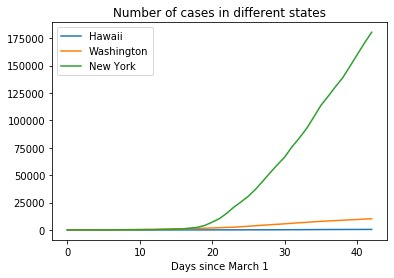

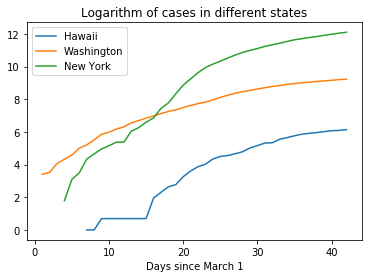

Growth rate in Hawaii is 0.19656274500417717
Growth rate in Washington is 0.1342230063129484
Growth rate in New York is 0.2580507854434324


In [19]:
fig, ax = plt.subplots()
ax.plot(days, cases_by_state[10], label='Hawaii')
ax.plot(days, cases_by_state[46], label='Washington')
ax.plot(days, cases_by_state[33], label='New York')
plt.title('Number of cases in different states')
plt.xlabel('Days since March 1')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(days[cases_by_state[10] > 0], np.log(cases_by_state[10][cases_by_state[10] > 0]), label='Hawaii')
ax.plot(days[cases_by_state[46] > 0], np.log(cases_by_state[46][cases_by_state[46] > 0]), label='Washington')
ax.plot(days[cases_by_state[33] > 0], np.log(cases_by_state[33][cases_by_state[33] > 0]), label='New York')
plt.title('Logarithm of cases in different states')
plt.xlabel('Days since March 1')
plt.legend()
plt.show()

print('Growth rate in Hawaii is', target[10])
print('Growth rate in Washington is', target[46])
print('Growth rate in New York is', target[33])

Counterintuitively, Washington state has a much smaller growth rate than Hawaii (in fact, it's the lowest growth rate out of all states!), and yet the number of cases is more than two orders of greater.

This speaks to several significant facts: (1) the exponential growth in Washington started much earlier as cases were first detected over a week prior to Hawaii, and (2) Washington state is significantly more populous and outbreaks were centered in areas of high density. Perhaps this might indicate that earlier action on by the local government significantly slowed the spread (the coronavirus threat was not known widely when it began to occur in Washington, compared to Hawaii where the first cases happened much later).

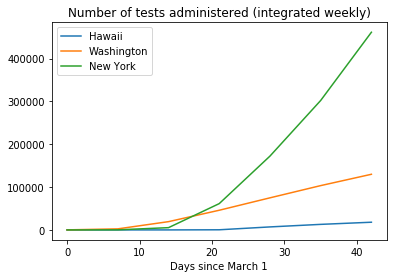

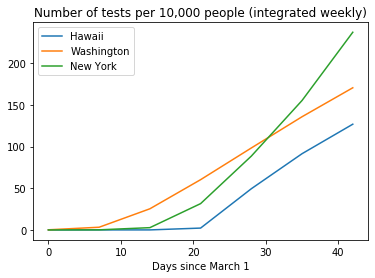

In [20]:
fig, ax = plt.subplots()
ax.plot(week, testing_by_week[10], label='Hawaii')
ax.plot(week, testing_by_week[46], label='Washington')
ax.plot(week, testing_by_week[33], label='New York')
plt.title('Number of tests administered (integrated weekly)')
plt.xlabel('Days since March 1')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(week, testing_per_pop[10], label='Hawaii')
ax.plot(week, testing_per_pop[46], label='Washington')
ax.plot(week, testing_per_pop[33], label='New York')
plt.title('Number of tests per 10,000 people (integrated weekly)')
plt.xlabel('Days since March 1')
plt.legend()
plt.show()

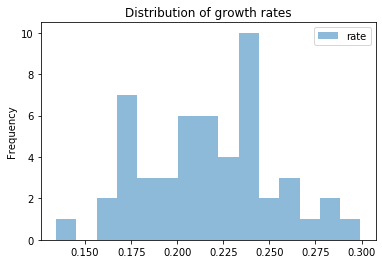

In [21]:
ax = targetdf.plot.hist(bins=15, alpha=0.5, title='Distribution of growth rates')

The data roughly follows a normal distribution and has a relatively significant spread in value with a majority being grouped around the average (0.21)

# A minimally complex model

The growth rate will be modeled using a basic, single neuron linear regression approximation.

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
# Generate test and training data splits
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=445)

# Determine predictor using linear regression
reg = LinearRegression(fit_intercept=True).fit(X_train, y_train)
predictor = np.array(reg.coef_).reshape(1,-1)

In [24]:
# Test linear regression
pred_values = reg.predict(X_train)
mse = np.sqrt( np.mean((pred_values - y_train) ** 2 ) )
print('Loss with linear regression: ', mse) 

Loss with linear regression:  0.015185437664064595


In [25]:
# Compare to trivial predictor
trivial_mse = np.sqrt( np.mean( (np.mean(y_train) - y_test)**2 ) )
print('Trivial predictor: ', trivial_mse)

Trivial predictor:  0.03621467028897064


Now repeat the test for several different training and testing sets:

In [26]:
mse = []
trivial_mse = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33)
    reg = LinearRegression(fit_intercept=True).fit(X_train, y_train)

    pred_values = reg.predict(X_train)
    mse = np.append(mse, np.sqrt( np.mean((pred_values - y_train) ** 2 ) ))
    
    trivial_mse = np.append(trivial_mse, np.sqrt( np.mean( (np.mean(y_train) - y_test)**2 ) ))

In [27]:
error = np.append(mse.reshape(-1,1), trivial_mse.reshape(-1,1), axis=1)
errdf = pd.DataFrame(error, columns=['LinReg', 'Trivial'])
errdf.describe()

,LinReg,Trivial
count,100.000000,100.000000
mean,0.017665,0.036291
std,0.002272,0.004927
min,0.012576,0.021769
25%,0.016131,0.033486
50%,0.017738,0.037177
75%,0.019075,0.040093
max,0.022837,0.045485


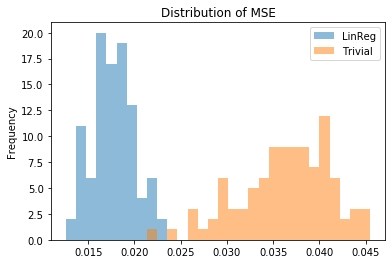

In [28]:
ax = errdf.plot.hist(bins=30, alpha=0.5, title='Distribution of MSE')

In [30]:
from sklearn.linear_model import Lasso
import statsmodels.api as sm

# Center data with constant
train_data_centered = sm.add_constant(data)

# Run Lasso
lasso = Lasso(normalize = True,alpha = 0.0008).fit(train_data_centered,target)
print(np.round(lasso.sparse_coef_,4))

# Print most significant features
selected_features = [1,2,10,11,14,15]
selected_feature_names = [datadf.columns[i] for i in selected_features]

print(selected_feature_names)

  (0, 1)	-0.0079
  (0, 2)	-0.0015
  (0, 10)	-0.0001
  (0, 11)	-0.0002
  (0, 14)	0.0004
  (0, 15)	0.012700000000000001
['Tests 2', 'Tests 3', 'gatherings', 'travel', 'restauraunts', 'retail']


Evidently, the LASSO picked out features corresponding to early testing numbers and restrictions on public interactions such as gatherings and shopping to be the most significant.